In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('data/oridata_to0704.csv')
df.head()

,日付,北海道,青森県,岩手県,宮城県,秋田県,山形県,福島県,茨城県,栃木県,...,愛媛県,高知県,福岡県,佐賀県,長崎県,熊本県,大分県,宮崎県,鹿児島県,沖縄県
0,2020/01/16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020/01/17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020/01/18,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020/01/19,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2020/01/20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df = df.T
df.columns = df.iloc[0]
df.drop(df.index[0], inplace=True)
df = df.reset_index()
df.rename(columns={'index': '県'}, inplace=True)

# 全体のデータ整形完了

In [122]:
# 特定の県だけに絞り、グループごとに以降のモデルを作成する
df = df[df['県'].isin(['北海道'])]
df = df[df['県'].isin(['青森県','岩手県','宮城県','秋田県','山形県','福島県'])]
df = df[df['県'].isin(['茨城県','栃木県','群馬県'])]
df = df[df['県'].isin(['埼玉県','千葉県','東京都','神奈川県'])]
df = df[df['県'].isin(['新潟県','富山県','石川県','福井県','山梨県','長野県','岐阜県','静岡県','愛知県'])]
df = df[df['県'].isin(['三重県','滋賀県','京都府','大阪府','兵庫県','奈良県','和歌山県'])]
df = df[df['県'].isin(['鳥取県','島根県','岡山県','広島県','山口県'])]
df = df[df['県'].isin(['徳島県','香川県','愛媛県','高知県'])]
df = df[df['県'].isin(['福岡県','佐賀県','長崎県','熊本県','大分県','宮崎県','鹿児島県','沖縄'])]

In [5]:
df.drop(df.columns[0], axis=1, inplace=True)
df.head()

日付,2020/01/16,2020/01/17,2020/01/18,2020/01/19,2020/01/20,2020/01/21,2020/01/22,2020/01/23,2020/01/24,2020/01/25,...,2020/06/25,2020/06/26,2020/06/27,2020/06/28,2020/06/29,2020/06/30,2020/07/01,2020/07/02,2020/07/03,2020/07/04
0,0,0,0,0,0,0,0,0,0,0,...,6,5,1,17,11,13,4,8,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,2,0,0,1,0,2,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


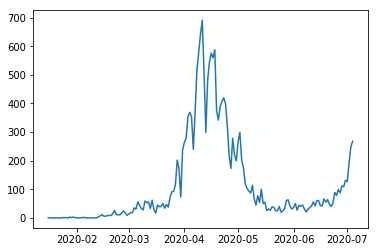

In [6]:
daily_global = df.sum(axis=0)
daily_global = daily_global.astype(int)
daily_global.index = pd.to_datetime(daily_global.index)
plt.plot(daily_global)

In [7]:
y = daily_global.values.astype(float)

In [8]:
def sequence_creator(input_data,window):
    dataset = []
    data_len = len(input_data)
    for i in range(data_len - window):
        window_fr = input_data[i:i+window]
        label = input_data[i+window:i+window+1]
        dataset.append((window_fr, label))
    return dataset

In [9]:
class LSTM_Corona(nn.Module):
    def __init__(self, in_size=1, h_size=30, out_size=1):
        super().__init__()
        self.h_size = h_size
        self.lstm = nn.LSTM(in_size,h_size)
        self.fc = nn.Linear(h_size,out_size)
        self.hidden = (torch.zeros(1,1,h_size),torch.zeros(1,1,h_size))
        
    def forward(self, sequence_data):
        lstm_out, self.hidden = self.lstm(sequence_data.view(len(sequence_data),1,-1),self.hidden) # データサイズ、バッチサイズ、隠れ層サイズ
        pred=self.fc(lstm_out.view(len(sequence_data),-1))
        
        return pred[-1]

In [10]:
torch.manual_seed(1)
model = LSTM_Corona()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)

# 直近14日間を予測

In [13]:
test_size = 14 # テスト日数
train_original_data = y[:-test_size]
test_original_data = y[-test_size:]

In [14]:
scaler= MinMaxScaler(feature_range=(-1,1))

train_normalized = scaler.fit_transform(train_original_data.reshape(-1,1))
train_normalized = torch.FloatTensor(train_normalized).view(-1)
train_normalized.shape

window_size = 15
train_data = sequence_creator(train_normalized, window_size)

In [15]:
epochs = 30

for epoch in range(epochs):
    for sequence_in, y_train in train_data:
        y_pred = model(sequence_in)
        loss = criterion(y_pred, y_train)
        
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.h_size),torch.zeros(1,1,model.h_size))
        
        loss.backward()
        optimizer.step()
        
    print(f'Epoech {epoch+1} Loss {loss.item():.7f}')

Epoech 1 Loss 0.5109494
Epoech 2 Loss 0.2261054
Epoech 3 Loss 0.0059536
Epoech 4 Loss 0.0029575
Epoech 5 Loss 0.0013571
Epoech 6 Loss 0.0005909
Epoech 7 Loss 0.0001988
Epoech 8 Loss 0.0000287
Epoech 9 Loss 0.0000053
Epoech 10 Loss 0.0000826
Epoech 11 Loss 0.0002283
Epoech 12 Loss 0.0004166
Epoech 13 Loss 0.0006261
Epoech 14 Loss 0.0008384
Epoech 15 Loss 0.0010381
Epoech 16 Loss 0.0012136
Epoech 17 Loss 0.0013571
Epoech 18 Loss 0.0014645
Epoech 19 Loss 0.0015354
Epoech 20 Loss 0.0015720
Epoech 21 Loss 0.0015783
Epoech 22 Loss 0.0015594
Epoech 23 Loss 0.0015206
Epoech 24 Loss 0.0014675
Epoech 25 Loss 0.0014049
Epoech 26 Loss 0.0013376
Epoech 27 Loss 0.0012697
Epoech 28 Loss 0.0012049
Epoech 29 Loss 0.0011463
Epoech 30 Loss 0.0010966


In [17]:
test = 14

preds = train_normalized[-window_size:].tolist()

# 評価モードに切替
model.eval()

for i in range(test):
    sequence = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.h_size), torch.zeros(1,1,model.h_size))
        preds.append(model(sequence).item())
        
# 予測データを正規化前に戻す
predictions = scaler.inverse_transform(np.array(preds).reshape(-1,1))

x = np.arange('2020-06-20','2020-07-04', dtype='datetime64[D]').astype('datetime64[D]')

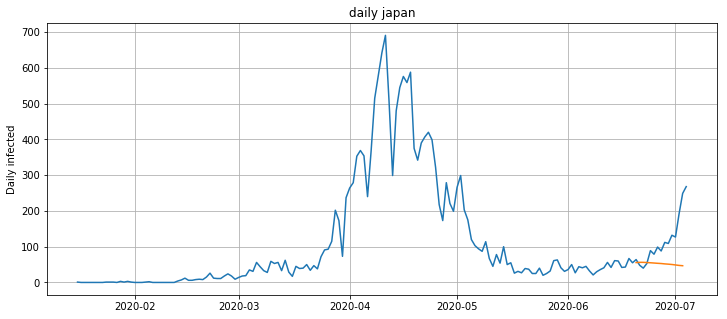

In [18]:
plt.figure(figsize=(12,5))
plt.title('daily japan')
plt.grid(True)
plt.plot(daily_global)
plt.ylabel('Daily infected')
plt.plot(x, predictions[window_size:])

# 未来予測

In [19]:
epochs = 100
model.train()

y_normalized = scaler.fit_transform(y.reshape(-1,1))
y_normalized = torch.FloatTensor(y_normalized).view(-1)
full_data = sequence_creator(y_normalized, window_size)

In [20]:
for epoch in range(epochs):
    for sequence_in, y_train in full_data:
        
        y_pred = model(sequence_in)
        loss = criterion(y_pred, y_train)
        
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.h_size),torch.zeros(1,1,model.h_size))
        
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 5 ==0:
        print(f'Epoch {epoch+1} Loss{loss.item():.7f}')

Epoch 5 Loss0.0450066
Epoch 10 Loss0.0254495
Epoch 15 Loss0.0184423
Epoch 20 Loss0.0157703
Epoch 25 Loss0.0145231
Epoch 30 Loss0.0138485
Epoch 35 Loss0.0134474
Epoch 40 Loss0.0131981
Epoch 45 Loss0.0130471
Epoch 50 Loss0.0129701
Epoch 55 Loss0.0129568
Epoch 60 Loss0.0130027
Epoch 65 Loss0.0131017
Epoch 70 Loss0.0132386
Epoch 75 Loss0.0133766
Epoch 80 Loss0.0134451
Epoch 85 Loss0.0133573
Epoch 90 Loss0.0130773
Epoch 95 Loss0.0126729
Epoch 100 Loss0.0122653


In [21]:
future = 15
preds = y_normalized[-window_size:].tolist()
model.eval()

for i in range(future):
    sequence = torch.FloatTensor(preds[-window_size:])
    
    with torch.no_grad():
        model.hidden =(torch.zeros(1,1,model.h_size),torch.zeros(1,1,model.h_size))
        preds.append(model(sequence).item())

# 予測データを正規化前に戻す
predictions = scaler.inverse_transform(np.array(preds).reshape(-1,1))

x = np.arange('2020-07-05','2020-07-20', dtype='datetime64[D]').astype('datetime64[D]')

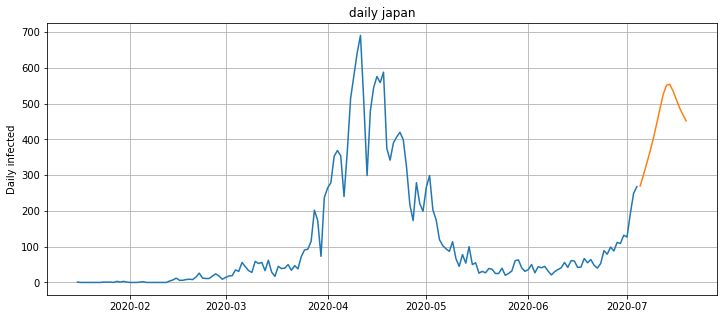

In [22]:
plt.figure(figsize=(12,5))
plt.title('daily japan')
plt.grid(True)
plt.plot(daily_global)
plt.ylabel('Daily infected')
plt.plot(x, predictions[window_size:])

In [24]:
result = pd.DataFrame(predictions)
result

,0
0,63.999998
1,47.999993
2,39.999991
3,53.000010
4,89.000000
5,79.000008
6,98.999993
7,88.000005
8,111.999991
9,109.000006


# 以上